<a href="https://colab.research.google.com/github/replicable/ai-reg/blob/main/transparency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

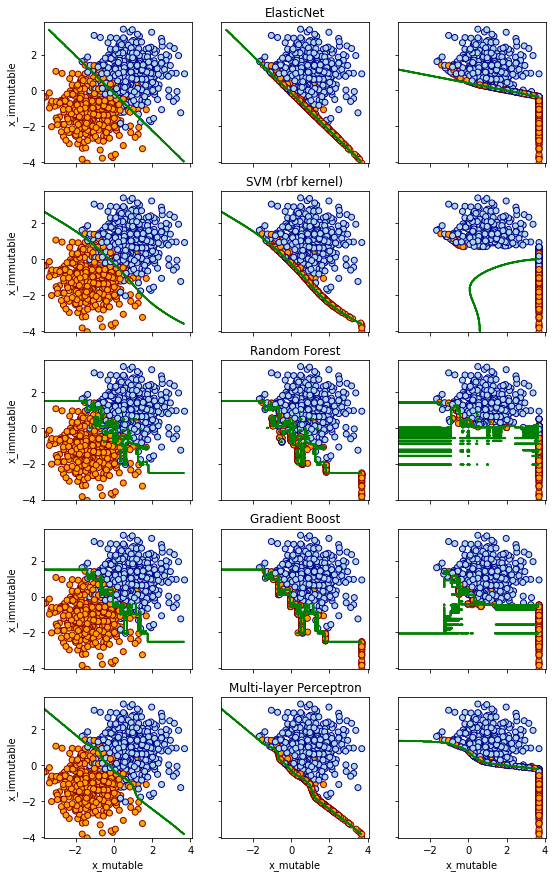

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn import linear_model, svm, ensemble, neural_network
import matplotlib.pyplot as plt

density, interval, seed = 400, .02, 0
cov = np.array([[1, 0], [0, 1]])
dist = [multivariate_normal(cov=cov, mean=np.array([i, i]), seed=seed).rvs(size=density) for i in [-1, 1]]
data = np.array([dist[j%2][int(j/2)] for j in range(density * 2)])
x_min, x_max = min(data[:, 0]), max(data[:, 0])
y_min, y_max = min(data[:, 1]), max(data[:, 1])
x_range, y_range = np.arange(x_min, x_max, interval), np.arange(y_min, y_max, interval)
XX, YY = np.meshgrid(x_range, y_range)
y = [0, 1] * density
classifiers = {'ElasticNet': linear_model.LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=seed), 
               'SVM (rbf kernel)': svm.SVC(kernel='rbf', random_state=seed), 
               'Random Forest': ensemble.RandomForestClassifier(random_state=seed),
               'Gradient Boost': ensemble.GradientBoostingClassifier(random_state=seed),
               'Multi-layer Perceptron': neural_network.MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=seed)}
size = len(classifiers)
colors, edgecolors = ['orange', 'lightblue'] * density, ['darkred', 'darkblue'] * density

def fit(classifier, data):
  clf = classifier
  clf.fit(data, y)
  boundary = clf.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
  return boundary

def game(data, boundary):
  gamed_data = np.copy(data)
  for i in range(density * 2):
    pred = boundary[int((data[i, 1] - y_min) / interval)]
    if pred[-1] == 1:
      x_ = x_range[np.nonzero(pred)[0][0]]
      gamed_data[i, 0] = min(max(gamed_data[i, 0], x_ + interval), x_max)
    else:
      gamed_data[i, 0] = x_max
  return gamed_data

def repeat_game(classifier, gamed_data):
  while(True):
    updated_data = game(gamed_data, fit(classifier, gamed_data))
    if np.array_equal(updated_data, gamed_data):
      return updated_data
    gamed_data = updated_data

def plot(ax, data, boundary):
    ax.scatter(data[:, 0], data[:, 1], c = colors, edgecolors = edgecolors, marker='o', alpha=1)
    ax.contour(XX, YY, boundary, colors='green')

fig, axs = plt.subplots(size, 3)
fig.set_size_inches(9, size * 3)
for i in range(size):
  classifier = list(classifiers.values())[i]
  boundary = fit(classifier, data)
  plot(axs[i][0], data, boundary)
  gamed_data = game(data, boundary)
  plot(axs[i][1], gamed_data, boundary)
  converged_data = repeat_game(classifier, gamed_data)
  plot(axs[i][2], converged_data, fit(classifier, converged_data))
  axs[i][1].set_title(list(classifiers.keys())[i])
for ax in axs.flat:
    ax.set(xlabel='x_mutable', ylabel='x_immutable')
for ax in axs.flat:
    ax.label_outer()
plt.show()